# <font color='blue'> Table Of Contents </font>

### <font color='blue'> Pre-requisite </font>

### <font color='blue'> Application Architecture </font>

### <font color='blue'> Script Walkthrough </font>

### <font color='blue'> Script Deployment </font>

### <font color='blue'> References </font>



# <font color='blue'> Pre-requisite </font>

In this lab, we are going to deploy a 3-tier application architecture on AWS using Terraform

This exercise will show you how the provisioning of infrastructure can be automated using machine readable code. 

We are going to need the following software in order to perform this lab:
- aws-cli (To communicate with AWS)
- terraform

You can do all of these in your AWS Educate account. You can also use a generic AWS account. 

# <font color='blue'> Application Architecture </font>

Below is the high level architecture of the 3-tier application that we are going to build as part of this lab. 

We wil be deploying the following resources as part of this exercise.
* A custom VPC with an attached Internet Gateway
* 2 public subnet with their respective route tables
* 4 EC2 instances, 2 in each subnet
* An Application Load balancer
* A DynamoDB Table

All of the mentioned resources will be deployed in the us-east-1 region. 


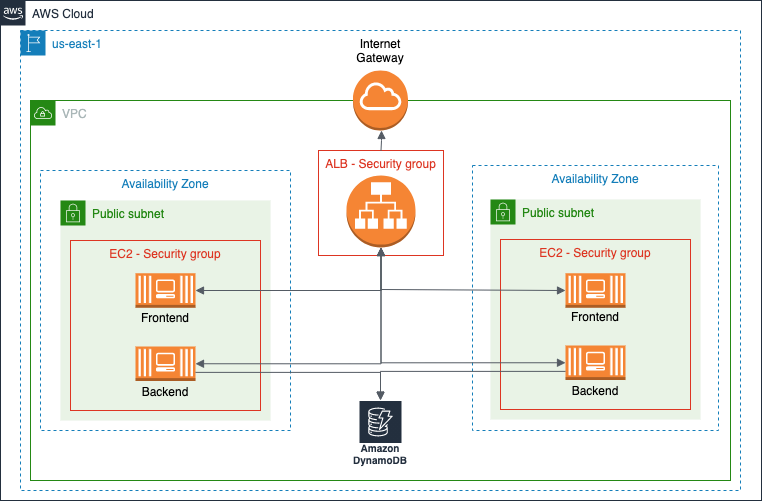

# <font color='blue'> Script Walkthrough </font>

A Terraform script is written in HCL(Hashicorp Configuration Language). It uses a declarative format, where the required resources are declared as variables, with an accompanying set of properties. 

Let us go over how these resources are being declared one at a time and some of their properties. 

### <font color='blue'> VPC </font>
```

 resource "aws_vpc" "test-vpc" {
    cidr_block = "10.0.0.0/16"
    enable_dns_support = "true" #gives you an internal domain name
    enable_dns_hostnames = "true" #gives you an internal host name
    enable_classiclink = "false"
    instance_tenancy = "default"    
    
    tags =  {
        Name = "test-vpc"
    }
}
```
The VPC resources uses the following properties above
* **cidr_block** : This specifies the CIDR IP address block to be used with the VPC. All the CIDR rules dictated by AWS will apply when CIDR rules are specified for VPCs and subnets using Terraform.
* **enable_dns_hostnames** : This will map a DNS name to every resource created within the VPC.
* **enable_dns_support** : This is a boolean value to be set to true or false depending on whether DNS support is required. Note that this must be true if EnableDnsHostnames is also set to true. 
* **tags** : These are key value pairs that are used as labels with AWS resources. 

### <font color='blue'> Subnet </font>

```
resource "aws_subnet" "public-subnet1" {
    vpc_id = "${aws_vpc.test-vpc.id}"
    cidr_block = "10.0.1.0/24"
    map_public_ip_on_launch = "true" //it makes this a public subnet
    availability_zone = "us-east-1a"
    tags = {
        Name = "public-subnet1"
    }
}
```
The following properties needs to be declared for the Subnet resource

* **vpc_id** : This property is used to declare the ID of the VPC where the subnet is to be deployed. In this case, we have used the custom VPC created in this exercise as a reference. Using this method, the creation of the subnet will be paused while the VPC is being created to avoid missing references
* **cidr_block** : This is is used to denote the CIDR block to be used for the VPC. 
* **availability_zone** : This denotes the availability zone where this subnet will reside. This needs to be within the region the VPC has been deployed in. 
* **map_public_ip_on_launch** : This is a boolean value used to state whether the resources created within this subnet will be allocated Public IPv4 addresses. If EnableDnsHostnames is true for the VPC, then a public DNS hostname will ne allocated as well. 

The above properties also apply to the resource public-subnet2 created in this exercise. 

### <font color='blue'> SecurityGroup </font>

```
resource "aws_security_group" "instance" {
  name = "terraform-example-instance"
  vpc_id = "${aws_vpc.test-vpc.id}"


  egress {
        from_port = 0
        to_port = 0
        protocol = -1
        cidr_blocks = ["0.0.0.0/0"]
  }

  # Inbound HTTP from anywhere
  ingress {
    from_port   = 80
    to_port     = 80
    protocol    = "tcp"
    cidr_blocks = ["0.0.0.0/0"]
  }
  ingress {
    from_port   = 22
    to_port     = 22
    protocol    = "tcp"
    cidr_blocks = ["0.0.0.0/0"]
  }
}
```

The SecurityGroup resources requires you to specify the following properties
* **Ingress** : This property is used to specify a rule for incoming traffic. In this exercise, we have opened ports 22 and 80 from all sources in the security group 

To specify the rules for outgoing traffic, we need to add a property called **Egress**. If this property is not specified, the security group will automatically be set to open for all outgoing connections. 

### <font color='blue'> EC2 Instance </font>

```
resource "aws_instance" "frontend1" {
  ami                    = "ami-0d5eff06f840b45e9"
  instance_type          = "t2.micro"
  vpc_security_group_ids = [aws_security_group.instance.id]
  subnet_id = "${aws_subnet.public-subnet1.id}"
  key_name = "trrfm"

  tags = {
    Name = "frontend1"
  }
}
```
The Instance resource is used to create an EC2 instance using the following properties 
* **instance_type** : This is used to specifty the size of the instance being created.
* **ami** : This property contains the Image ID of the AMI which is to be installed in the instance. In this case, we are using the Image ID of the Amazon Linux 2 AMI in the us-east-1 region. 
* **key_name** : This will contain the name of the key pair  to be used with the instance. The key-pair must be a pre-existing one. 
* **subnet_id** : This property contains the description of the subnet where the instance has been created.
* **vpc_security_group_ids** : This contains the ID of the security group used with the instances 

The above properties also apply to the instances BackEnd1, FrontEnd2 and BackEnd2 declared in the script. 

### <font color='blue'> InternetGateway </font>
 ```
 resource "aws_internet_gateway" "test-igw" {
    vpc_id = "${aws_vpc.test-vpc.id}"
    tags = {
        Name = "test-igw"
    }
}
```
The Internet Gateway resources will only contain the ID of the VPC where it is to be deployed, using the variable aws_internet_gateway.

### <font color='blue'> RouteTable </font>
```
resource "aws_route_table" "public-rt" {
    vpc_id = "${aws_vpc.test-vpc.id}"
    
    route {
        cidr_block = "0.0.0.0/0" 
        gateway_id = "${aws_internet_gateway.test-igw.id}" 
    }
    
    tags = {
        Name = "public-rt"
    }
}
```
This resource is used to create the route tables required for the subnets we have created. In its properties, we have specified the VPC to be used for the route table creation. Also, in the resources below , we have associated it with the required subnets
```
resource "aws_route_table_association" "crta-public-subnet-1"{
    subnet_id = "${aws_subnet.public-subnet1.id}"
    route_table_id = "${aws_route_table.public-rt.id}"
}

resource "aws_route_table_association" "crta-public-subnet-2"{
    subnet_id = "${aws_subnet.public-subnet2.id}"
    route_table_id = "${aws_route_table.public-rt.id}"
}
```
### <font color='blue'> Application Load Balancer </font>

```
resource "aws_lb" "test" {
  name               = "test-lb-tf"
  internal           = false
  load_balancer_type = "application"
  security_groups    = [aws_security_group.instance.id]
  subnets            = [aws_subnet.public-subnet1.id,aws_subnet.public-subnet2.id]

  enable_deletion_protection = true

  tags = {
    Name = "test"
  }
}

```

The LoadBalancer resource can be used to create an Application, Network or Gateway Load Balancer. Note the following salient feature regarding its properties : 
* Since we have mentioned the type of load balancer to be deployed here, Terraform will deploy an Application Load Balancer
* Atleast 2 subnets from different availability zones have to be specified
* We are using the same security group as the one used with the EC2 instances. 


### <font color='blue'> DynamoDB Table </font>

```
resource "aws_dynamodb_table" "test-dynamodb-table" {
  name           = "Test-table"
  billing_mode   = "PROVISIONED"
  read_capacity  = 20
  write_capacity = 20
  hash_key       = "UserId"
  range_key      = "GameTitle"

  attribute {
    name = "UserId"
    type = "S"
  }

  attribute {
    name = "GameTitle"
    type = "S"
  }

  attribute {
    name = "TopScore"
    type = "N"
  }

  ttl {
    attribute_name = "TimeToExist"
    enabled        = false
  }

  global_secondary_index {
    name               = "GameTitleIndex"
    hash_key           = "GameTitle"
    range_key          = "TopScore"
    write_capacity     = 10
    read_capacity      = 10
    projection_type    = "INCLUDE"
    non_key_attributes = ["UserId"]
  }
```

The DynamoDB::Table resource is used to create a DynamoDB table. It uses the following properties:
* **attribute** : These contains a list of attributes to be stored in the table. Ideally, non-key attributes need not be mentioned here.
* **global_secondary_index** : This is used to specify the key properties of the DynamoDB table



# <font color='blue'> Script Deployment </font>


The below instructions assume that you have already configured the AWS CLI tool on your local machine. 



1. Download the provided Terraform script to your local machine 
2.  Create a new key-pair file in your AWS account using the AWS console
3. Open the provided script using your text editor of choice and replace the key pair names in each of the instance resources with the key pair you have created. This change is to be made in lines 78,91,104 and 117. Make sure not to add the file extension. Save the script. 

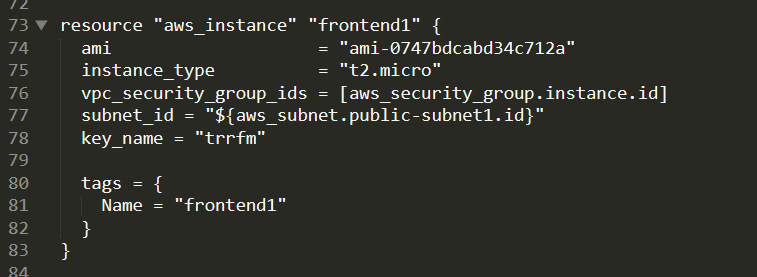






4. Download the Terraform application using the link below and unzip it. Copy the Terraform script to the same folder where the application has been unzipped. 
https://www.terraform.io/downloads.html


5. Run the commands below to create the execution plan for the script

```
terraform init
terraform plan
```
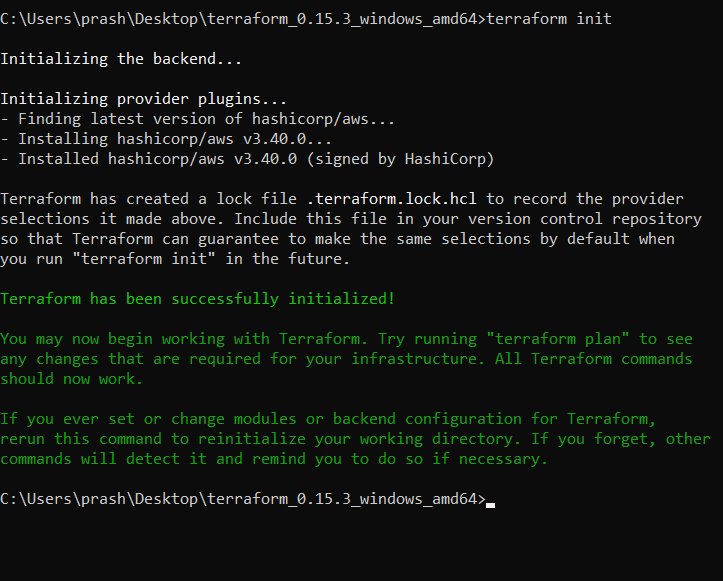



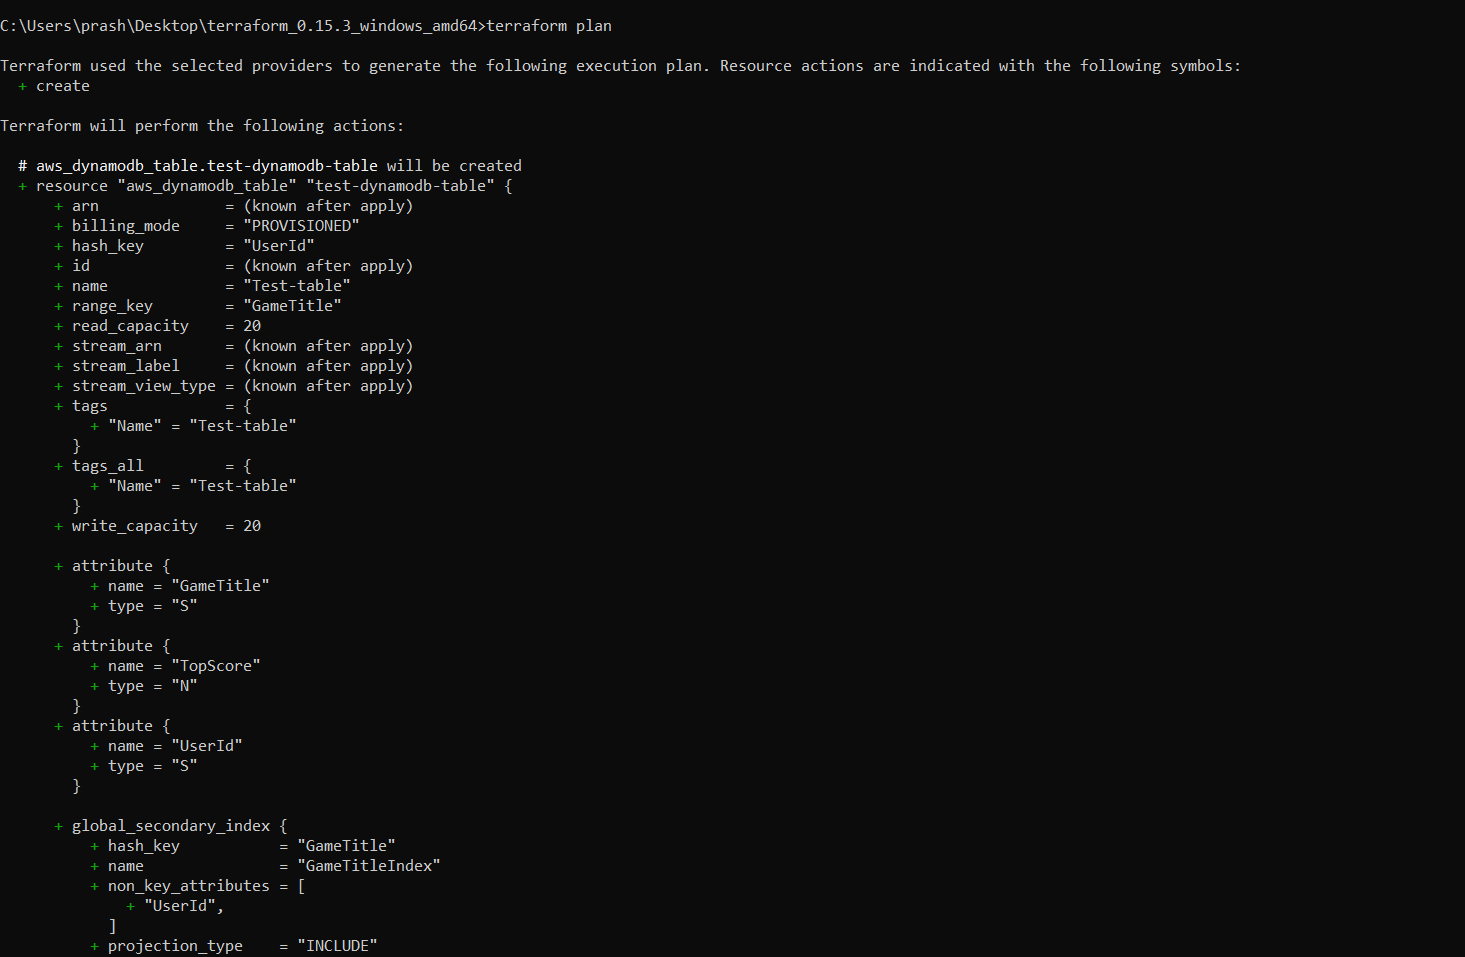


6. Run the below command to execute the script
```
terraform apply
```



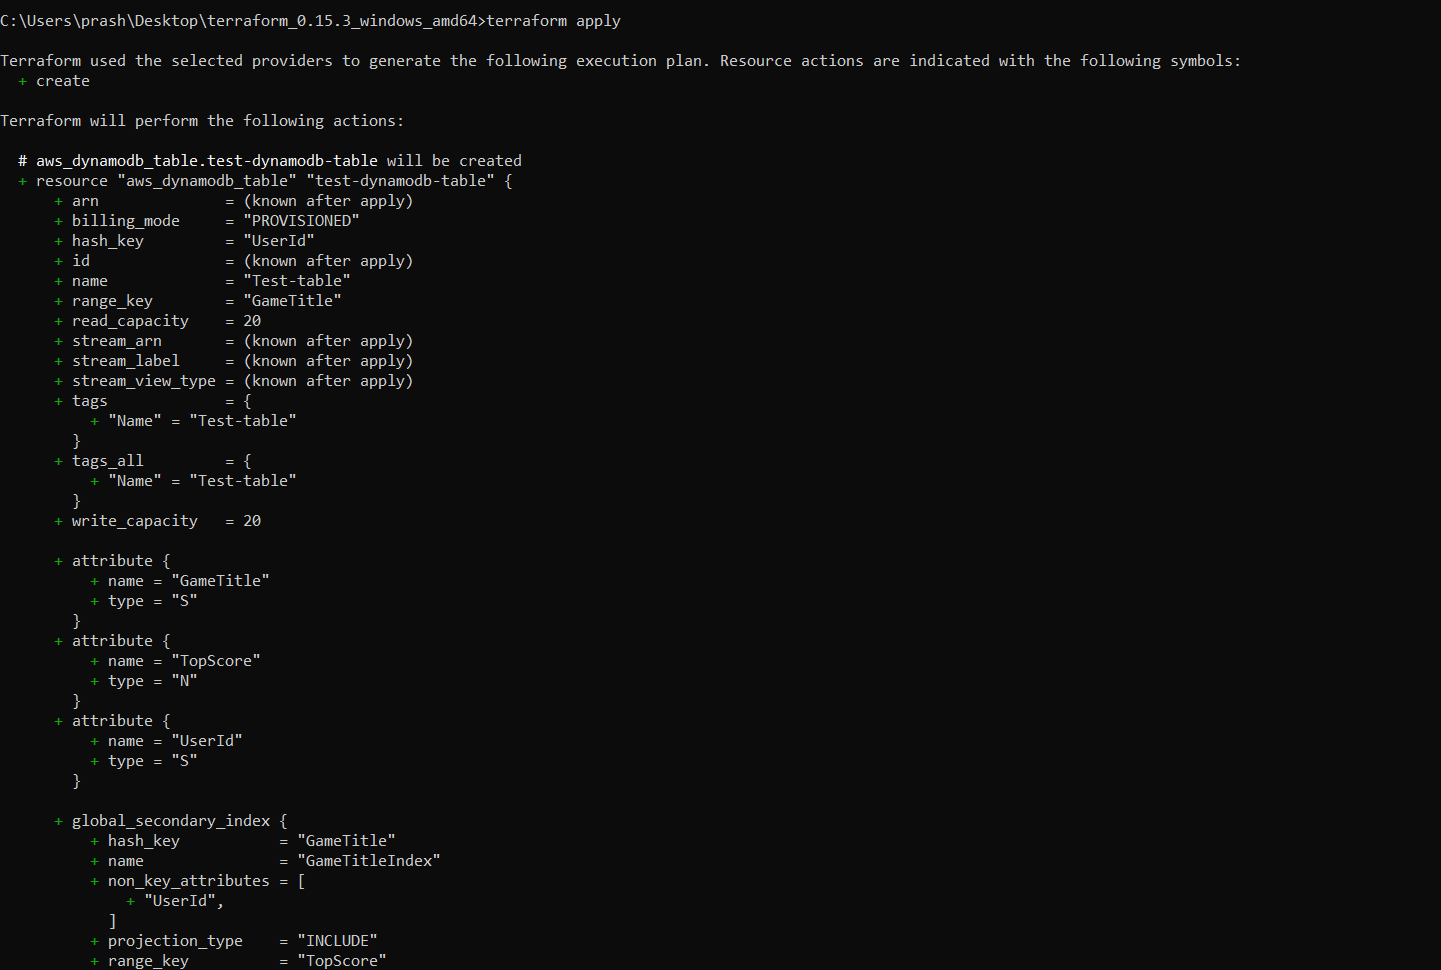

7. Once the creation of the stack is completed, navigate to each of the services declared as part of the script to observe if the resources have been deployed.  



8. Run the below command in the terminal to delete the stack and all resource created with it.

```
terraform destroy
```
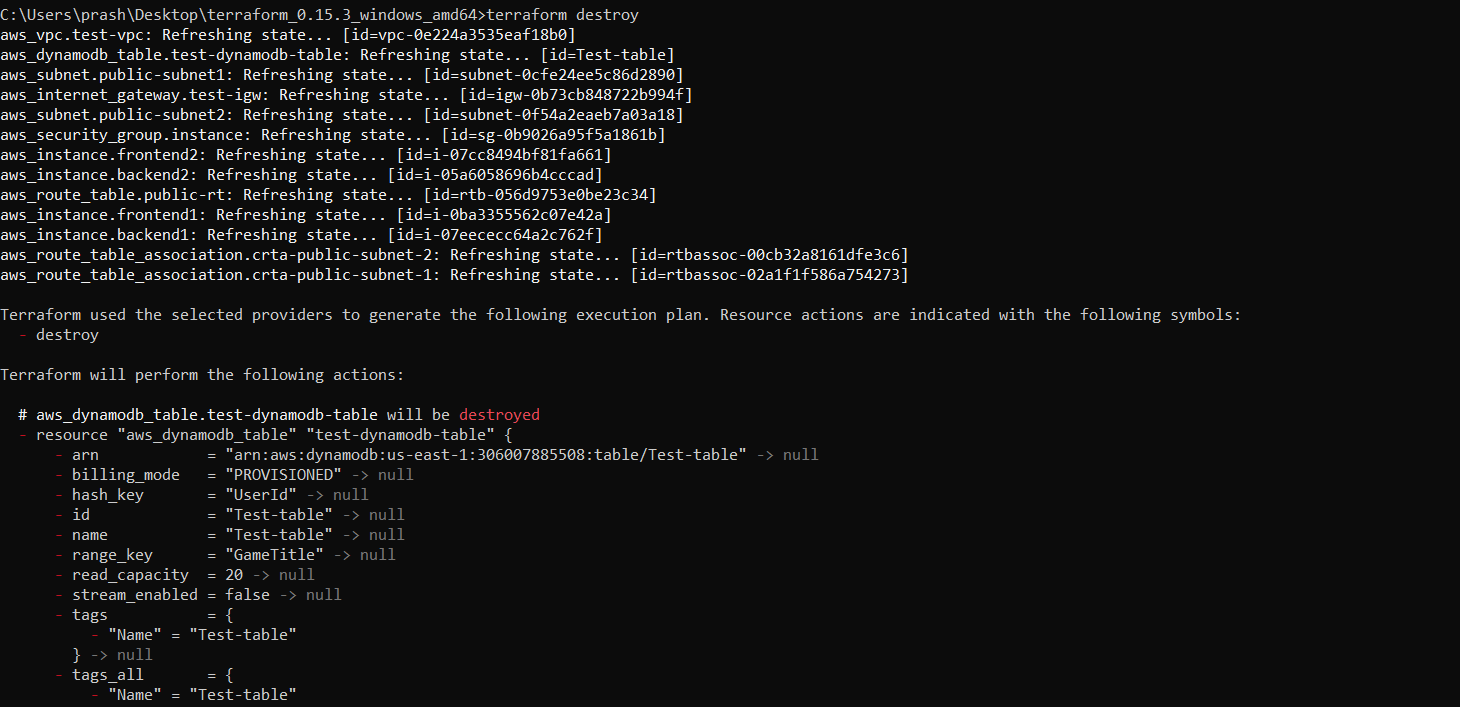

## <font color='blue'> References </font>

1. Terraform Documentation : https://www.terraform.io/

2. AWS DynamoDB Terraform Documentation : https://registry.terraform.io/providers/hashicorp/aws/latest/docs/resources/dynamodb_table

3. AWS VPC Terraform Documenatation : https://registry.terraform.io/providers/hashicorp/aws/latest/docs/resources/vpc

4. AWS Subnet Terraform Documentation : https://registry.terraform.io/providers/hashicorp/aws/latest/docs/resources/subnet

5. Terraform CLI reference : https://www.terraform.io/docs/cli/commands/index.html

